In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!ls
%cd drive/MyDrive/9444/group_ass/VOC2012

 label_map.json
 new_dumpsite_data
'Revealing influencing factors on global waste distribution via deep-learning based dumpsite detection from satellite imagery.pdf'
 VOC2012
[Errno 2] No such file or directory: 'drive/MyDrive/9444/group_ass/VOC2012'
/content/drive/MyDrive/9444/group_ass/VOC2012


In [32]:
!pip install ultralytics

In [34]:
import os
import xml.etree.ElementTree as ET
# from ultralytics import YOLO
from collections import defaultdict
import json
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import random
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, Rotate, RandomBrightnessContrast, Normalize, BboxParams
)
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2

## 1. Data Preprocessing
- Our dataset is from ScienceDB (scidb.cn), the url is : https://www.scidb.cn/en/s/6bq2M3</br>

- Datasets are in PASCAL VOC format</br>
- To facilitate uniform data reading, we point the current working directory to `/root` </br>
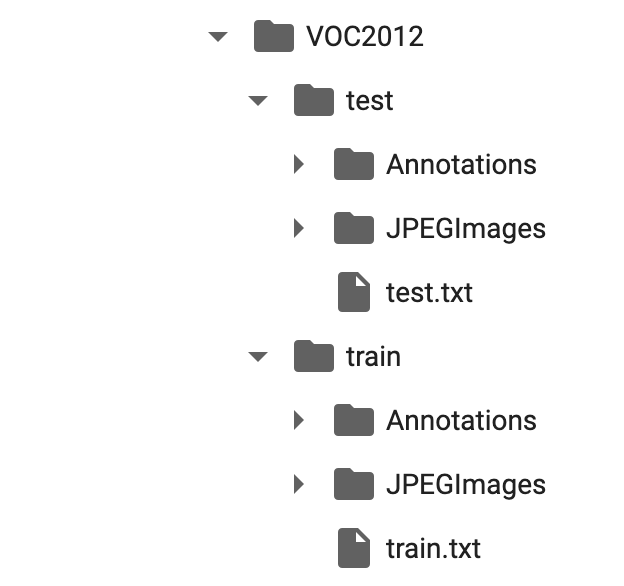

In [35]:
os.chdir('/content/drive/MyDrive/9444/group_ass')

In [6]:
# set the new dataset path
root_path = './new_dumpsite_data'
train_file_Annotations = os.path.join(root_path, "train", "Annotations")
test_file_Annotations = os.path.join(root_path, "test", "Annotations")

# Create directories if they do not exist
os.makedirs(train_file_Annotations, exist_ok=True)
os.makedirs(test_file_Annotations, exist_ok=True)

print(os.getcwd())
print(f"Train Annotations directory: {train_file_Annotations}")
print(f"Test Annotations directory: {test_file_Annotations}")

/content/drive/MyDrive/9444/group_ass
Train Annotations directory: ./new_dumpsite_data/train/Annotations
Test Annotations directory: ./new_dumpsite_data/test/Annotations


In [36]:
# convert annotation files to find How many labels are there
def convert_annotation_find_labels(path):
  labels = []
  for each_xml in os.listdir(path):
      pic_xml = os.path.join(path, each_xml)
      tree = ET.parse(pic_xml)
      root = tree.getroot()
      for ele in root.findall('object'):
          label = ele.find('name').text
          labels.append(label)
  set_labels = set(labels)
  print(path, set_labels)
  return labels

train_object_labels = convert_annotation_find_labels('VOC2012/train/Annotations')
test_object_labels = convert_annotation_find_labels('VOC2012/test/Annotations')

VOC2012/train/Annotations {'mining waste', 'industry waste', 'domestic garbage', 'construction waste', 'disposed garbage', 'agriculture forestry'}
VOC2012/test/Annotations {'domestic garbage', 'construction waste', 'agriculture forestry', 'disposed garbage'}


In [37]:
with open('./label_map.json', 'r') as json_file:
  label_map = json.load(json_file)
label_name = {v : k for k, v in label_map.items()}

In [38]:
# Number of statistics for each label
name_number = defaultdict(int)
for index, class_name in enumerate(train_object_labels):
  name_number[label_map[class_name]] += 1
  train_object_labels[index] = label_map[class_name]
print('train_object_labels', train_object_labels)

train_object_labels [0, 0, 0, 2, 0, 5, 5, 5, 5, 0, 0, 0, 0, 5, 0, 5, 5, 0, 5, 0, 5, 0, 5, 0, 0, 0, 0, 2, 0, 0, 0, 0, 5, 0, 5, 5, 5, 5, 5, 0, 2, 0, 2, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 2, 0, 0, 0, 0, 0, 5, 5, 0, 2, 0, 0, 0, 0, 5, 5, 5, 0, 0, 5, 5, 0, 5, 2, 0, 0, 0, 5, 2, 0, 5, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 5, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5

In [39]:
df = pd.Series(data=name_number.values(), index=list(label_name[name] for name in name_number.keys()), name="train_labels_distribution")
df
df.keys()
df.values

array([2301,  247,  581,    9,    1,    1])

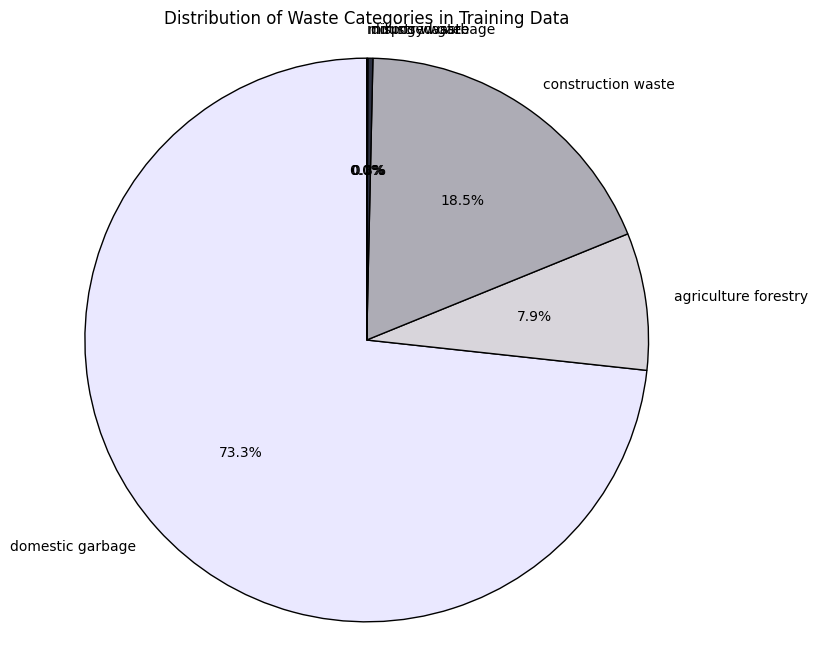

In [15]:
# Percentage of each category of visualization
# Create a pie chart
plt.figure(figsize=(8, 8))  # Optional: to make the pie chart bigger

plt.pie([2301, 247, 581, 9, 1, 1],
    labels=list(label_name[name] for name in name_number.keys()),
    autopct='%1.1f%%',  # Display percentage with one decimal place
    startangle=90,      # Rotate the start of the pie chart
    wedgeprops={'edgecolor': 'black'},  # Add border to slices for clarity
    colors=['#EAE8FF','#D8D5DB','#ADACB5','#2D3142', '#B0D7FF', '#FFB3E6'])  # Custom colors

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title (Optional)
plt.title('Distribution of Waste Categories in Training Data')

# Show the pie chart
plt.show()


In [40]:
def check_image_annotation_consistency(image_dir, annotation_dir):
    image_files = set([os.path.splitext(f)[0] for f in os.listdir(image_dir)])
    annotation_files = set([os.path.splitext(f)[0] for f in os.listdir(annotation_dir)])

    missing_images = annotation_files - image_files
    missing_annotations = image_files - annotation_files

    if missing_images:
        print(f"Missing images for annotations: {missing_images}")
    if missing_annotations:
        print(f"Missing annotations for images: {missing_annotations}")
    if not missing_images and not missing_annotations:
        print("All images and annotations are consistent.")

# Checking the consistency of the training and test sets
check_image_annotation_consistency('VOC2012/train/JPEGImages', 'VOC2012/train/Annotations')
check_image_annotation_consistency('VOC2012/test/JPEGImages', 'VOC2012/test/Annotations')

All images and annotations are consistent.
All images and annotations are consistent.


## Data Processing

As shown in the figure above, due to the uneven distribution of each category in the training set, it will lead to unfair training results, so we use data enhancement, category weight adjustment, and oversampling to make the proportion of images in each category reach a relative balance
- Data augmentation: data augmentation (rotation, translation, scaling, etc.) is applied to small categories to expand the sample size.
- Category weighting: assign larger weights to small categories during training to reduce the impact of category imbalance on the model.


In [41]:
class GarbageDataset(Dataset):
  def __init__(self, root, mode, output_dir=None, transforms=None):
    self.root = root
    self.mode = mode
    self.transforms = transforms
    self.image_dir = os.path.join(root, 'JPEGImages')
    self.annotation_dir = os.path.join(root, 'Annotations')
    self.output_image_dir = os.path.join(output_dir, mode, "JPEGImages")  # transform image saved directories
    self.output_annotation_dir = os.path.join(output_dir, mode, 'Annotations')  # transform annotation saved directories

    # If output_dir is specified and the directory does not exist, create the directory
    # Create output directories if they don't exist
    os.makedirs(self.output_image_dir, exist_ok=True)
    os.makedirs(self.output_annotation_dir, exist_ok=True)

    if mode == 'train':
      text_file = os.path.join(root, 'train.txt')
    elif mode == 'test':
      text_file = os.path.join(root, 'test.txt')
    elif mode == 'valid':
      text_file = os.path.join(root, 'train.txt')
    else:
      raise ValueError("Invalid mode. Use 'train', 'valid' or 'test'.")

    with open(text_file, 'r') as f:
      self.img_ids = f.read().strip().split()

  def __len__(self):
        return len(self.img_ids)

  def __getitem__(self, index):
    img_id = self.img_ids[index]
    img_path = os.path.join(self.image_dir, img_id + '.jpg')
    annotation_path = os.path.join(self.annotation_dir, img_id + '.xml')

    img = np.array(Image.open(img_path).convert('RGB'))

    # Parse the XMl annotation files
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Initialize lists for bounding boxes and labels
    boxes = []
    labels = []

    # Iterate over each obj in the XML files
    for obj in root.findall('object'):
        label = obj.find('name').text

        # Mapping the obj name to a label
        if label in label_map:
          labels.append(label_map[label])
        else:
          continue # skip labels that are not in the label_map

        # Extract bounding box coordinates
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Create a list for the bounding box coordinates
        box = [xmin, ymin, xmax, ymax]
        boxes.append(box)
    # Convert lists to tensors
    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)

    # Prepare the final target dictionary containing bounding boxes and labels
    target = {
        "boxes": boxes,
        "labels": labels
    }

    if self.transforms is not None:
      if self.mode == "train":
        while True:
          img_copy, target_copy = img.copy(), target.copy()
          transformed = self.transforms(image=img_copy, bboxes=target_copy['boxes'].tolist(), labels=target_copy['labels'].tolist())
          img_copy = transformed['image']
          target_copy['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
          target_copy['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)
          if torch.numel(target_copy['boxes']) > 0:
            img, target = img_copy, target_copy
            break
      else:
        img = self.transforms(img)

      if self.output_image_dir and self.output_annotation_dir:
        output_img_path = os.path.join(self.output_image_dir, img_id + ".jpg")
        processed_image = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)  # Convert to uint8 and back to RGB
        cv2.imwrite(output_img_path, cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))

        # Save the augmented XML annotation
        output_annotation_path = os.path.join(self.output_annotation_dir, img_id + '.xml')
        tree.write(output_annotation_path, encoding='utf-8', xml_declaration=True)

      return {'image':img, 'boxes':target['boxes'], 'labels':target['labels']}

  def unnormalize(self, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]
    return image * std + mean

In [42]:
# Define transformations using Albumentations for training
train_transform = Compose(
    [
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        Rotate(limit=90, p=0.5),
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()  # Convert to tensor after augmentations
    ],
    bbox_params=BboxParams(format='pascal_voc', label_fields=['labels'])
)

# Define transformations for testing/validation using Torchvision.transforms
test_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Apply normalization
])

# Organize transforms into a dictionary for easier access
transform = {
    "train": train_transform,
    "test": test_transform
}

In [43]:
train_dataset = GarbageDataset(root='VOC2012/train', mode='train', output_dir='./new_dumpsite_data', transforms=transform["train"])
val_dataset = GarbageDataset(root='VOC2012/train', mode='valid', output_dir='./new_dumpsite_data', transforms=transform["test"])
for idx in range(len(train_dataset)):
  sample = train_dataset[idx]  # This processes and saves the augmented images and annotations
  print(f"Train Dataset Processed {idx + 1}/{len(train_dataset)}: Image ID {train_dataset.img_ids[idx]}")
for idx in range(len(val_dataset)):
  sample = val_dataset[idx]  # This will save the validation set images and annotations (no augmentation applied)
  print(f"Validation Dataset Processed {idx + 1}/{len(val_dataset)}: Image ID {val_dataset.img_ids[idx]}")
  # if idx == 10:
    # break

Streaming output truncated to the last 5000 lines.
Train Dataset Processed 343/2671: Image ID 20189
Train Dataset Processed 344/2671: Image ID 20190
Train Dataset Processed 345/2671: Image ID 20191
Train Dataset Processed 346/2671: Image ID 20192
Train Dataset Processed 347/2671: Image ID 20193
Train Dataset Processed 348/2671: Image ID 20194
Train Dataset Processed 349/2671: Image ID 20195
Train Dataset Processed 350/2671: Image ID 20196
Train Dataset Processed 351/2671: Image ID 20197
Train Dataset Processed 352/2671: Image ID 20198
Train Dataset Processed 353/2671: Image ID 20199
Train Dataset Processed 354/2671: Image ID 20200
Train Dataset Processed 355/2671: Image ID 20201
Train Dataset Processed 356/2671: Image ID 20202
Train Dataset Processed 357/2671: Image ID 20203
Train Dataset Processed 358/2671: Image ID 20204
Train Dataset Processed 359/2671: Image ID 20205
Train Dataset Processed 360/2671: Image ID 20206
Train Dataset Processed 361/2671: Image ID 20207
Train Dataset Proc